## Mónica Villasuso López.
### Proyecto Individual - Datascience Bootcamp

## Clasificación de Lesiones Cutáneas usando KERAS - DATA AUGMENTATION

### `TOMA IMAGENES YA CONVERTIDAS A BLANCO Y NEGRO Y REDIMENSIONADAS`

Referencias uso de Data Augmentation:  
https://enmilocalfunciona.io/tratamiento-de-imagenes-usando-imagedatagenerator-en-keras/
https://datasmarts.net/es/como-usar-imagedatagenerator-para-entrenar-una-cnn-en-keras/
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html  
http://personal.cimat.mx:8181/~mrivera/cursos/aprendizaje_profundo/convnets_aumentadas/convnets_aumentadas.html



In [1]:
# Manejo de archivos y directorios
import os
from os import listdir
from os.path import isfile, join


# Básicas (álgebra, números aleatorios, carga de datos en dataframe, visualizacion)
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random
from random import shuffle

# Manejo de imágenes
import imageio
import cv2

# Guardar los modelos
import pickle
import json
import time

# Analítica Avanzada
# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# Redes Neuronales 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback  
from tensorflow.keras.preprocessing.image import ImageDataGenerator ,img_to_array


#Modulos del proyecto
from utils import apis_tb as a_tb
from utils import folders_tb as f_tb
from utils import models_tb as mod_tb
from utils import mining_data_tb as m_tb
from utils import visualization_tb as v_tb

## Antecedentes. Contexto  
=================================

## Carga de Datos  
=================================  
Debido a que se trata de un caso de Aprendizaje supervisado, los datos se encuentran bien diferenciados y almacenados en directorios separados según la categorización. Para este problema se han dividido en:  
* Malignos: Fotografías de lunares, manchas o lesiones de la piel que luego de ser estudiadas han sido diagnosticadas como * Malignas (Sospechosas) *  , es decir, con algún tipo de melanoma o condición que amerite tratamiento con un especialista  

* Benignos: Fotografías de lunares, manchas o lesiones de la piel que luego de ser estudiadas han sido diagnosticadas como * Benignas (Normales) *  sin que ameriten especial revisión médica.

In [2]:
my_path = os.getcwd()  #Guarda en esta variable el path inicial del main del proyecto
my_path

'/Users/purbina/Desktop/THE_BRIDGE/DS_MVL/PROYECTOS/projects/final/src'

In [3]:
SEED = 54

### (1) Preprocesamiento de las imágenes

In [4]:
gray_folder = "gray"
resize_folder = "resize"
benig_rel_path ="../resources/Benignos" 
malig_rel_path = "../resources/Malignos"
# Nombres de las clases (target)
class_names = ['Maligno','Benigno']  # (0=Maligno, 1=Benigno)

#### Crear directorios con las imágenes en Blanco y Negro y redimensionadas para el análisis

In [14]:
m_tb.preparar_datos(my_path,benig_rel_path,gray_folder, resize_folder)

161


In [15]:
m_tb.preparar_datos(my_path,malig_rel_path,gray_folder, resize_folder)


142


## (2) Carga de imágenes requeridas para el modelo

In [5]:
tipo_lunar=[]        #Lista donde se cargaran las expresiones corresp a las fotos (0 - Maligno, 1 Benigno)
X_data_img =[]
bgr_path= benig_rel_path+ "/"+ gray_folder + "/" + resize_folder
mgr_path= malig_rel_path+ "/"+ gray_folder + "/" + resize_folder

In [6]:

X_data_img , tipo_lunar = m_tb.lista_img (X_data_img,tipo_lunar, 1,  my_path, bgr_path)

In [7]:
X_data_img , tipo_lunar = m_tb.lista_img (X_data_img,tipo_lunar, 0,  my_path, mgr_path)

In [8]:
# (Lista con los nombres de todas las fotos para entrenar el modelo)
print("Imagenes: ", len(X_data_img), " - Clasif: ", len(tipo_lunar))      

Imagenes:  303  - Clasif:  303


In [9]:
random.seed(SEED)
#Shuffle de las 2 listas (conservando la relacion)
mapindexpos = list(zip(X_data_img,tipo_lunar))
random.shuffle(mapindexpos)
X_data_img,tipo_lunar = zip(*mapindexpos)

In [10]:
# Convertir la lista a np array
X = np.squeeze(X_data_img)
# Normalizacion de los datos
X = X.astype('float32')
X /= 255

## (3) Conjuntos de Entrenamiento y Test para el modelo

In [11]:
# Setting del tamaño del conjunto de entrenamiento
t_size=0.85
train_size = int(len(X) * t_size)

In [12]:
# Partición del conjunto de entrenamiento y test para entrenar el modelo
(train_images, train_labels), (test_images, test_labels) = (X[:train_size],np.array(tipo_lunar[:train_size])) , (X[train_size:] , np.array(tipo_lunar[train_size:]))

In [13]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((257, 48, 48), (257,), (46, 48, 48), (46,))

In [14]:
train_images_gr = train_images.reshape(train_images.shape[0], 48, 48, 1)
test_images_gr = test_images.reshape(test_images.shape[0], 48, 48, 1)

print("train_images_gr shape:", train_images_gr.shape)
print("test_images_gr shape:", test_images_gr.shape)

train_images_gr shape: (257, 48, 48, 1)
test_images_gr shape: (46, 48, 48, 1)


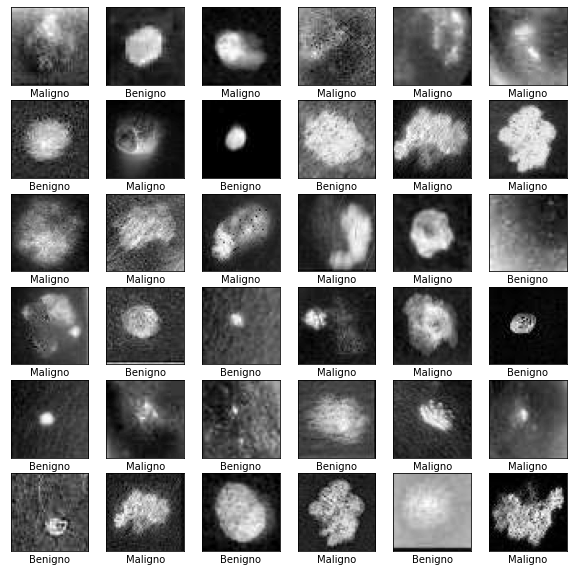

In [15]:
# Muestra las primeras 36 imagenes del conjunto de entrenamiento 
v_tb.plot_img(train_images,train_labels,6,class_names)

## (4) MODELO - CNN

In [16]:
EPOCHS= 100
BSIZE = 48

EL MEJOR accuracy se alcanzó con la siguientes características:  

Settings:  
Random seed = 43  
%Train = 85%  - % Test = 15%  
% Valid = 20%
----------  
Función de activación --> RELU   (en todas las capas)  
Optimizador --> Adam  
----------  
Una CNN con:  
    - 1 capa convolutiva con 8 neuronas  
    - 1 capa convolutiva con 16 neuronas  
    - 1 MaxPool quedando las dimensiones de la imagen a la mitad  
    - 1 dropout 0.25 
    - 1 capa convolutiva con 32 neuronas  
    - 1 MaxPool quedando las dimensiones de la imagen a la mitad  
    - 1 dropout 0.25  
    - 1 Flatten  
    - 1 dense con 32 neuronas  
    - 1 dense con 64 neuronas  
    - 1 dense con 2 (Softmax --> salida)


In [17]:
tf.config.run_functions_eagerly(True)

INPUT_SHAPE = (48,48,1)

model1 = keras.models.Sequential()

# First conv-pool layers - set 1
model1.add(keras.layers.Conv2D(filters=8, kernel_size=(3, 3), strides=(1, 1), 
activation="relu", padding="valid", input_shape=INPUT_SHAPE))
model1.add(keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="valid"))
model1.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
model1.add(keras.layers.Dropout(rate=0.25))
model1.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="valid"))
model1.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
model1.add(keras.layers.Dropout(rate=0.25))

# Flatten layer
model1.add(keras.layers.Flatten())

# Dense layers
model1.add(keras.layers.Dense(units=32, activation="relu"))
model1.add(keras.layers.Dense(units=64, activation="relu"))
# Output layer
model1.add(keras.layers.Dense(units=2, activation="softmax"))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 16)        1168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 22, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 10, 32)        0

In [18]:
# Compilar el modelo
# Distintos valores probados para el optimizador (*los mejores) : (*adam, *RMSprop, AdaMax, Adadelta, Adagrad)
model1.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=1e-4)  
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_delta=1e-4)  
callbacks_list = [early_stop, reduce_lr] 

In [20]:
# Usaremos 20% de la data de entrenamiento para validar el desempeño de la red en cada epoch.
X_train, X_valid, y_train, y_valid = train_test_split(train_images_gr, train_labels, train_size=0.8)
 

In [21]:
augmenter = ImageDataGenerator(horizontal_flip=True,
                               rotation_range=20, 
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               zoom_range=0.2,
                               shear_range=0.1,
                               fill_mode='nearest')
 

In [22]:
save_path = "../resources/DataAument/Gen_Model"

In [23]:
history = model1.fit(augmenter.flow(X_train, y_train, batch_size=BSIZE
#,save_to_dir=save_path, save_prefix= "t_", save_format = "png"   #Si se quieren guardar en disco
 ),
                        validation_data=augmenter.flow(X_valid, y_valid, batch_size=BSIZE),
                        steps_per_epoch= len(X_train) // BSIZE,
                        epochs=EPOCHS, callbacks=callbacks_list)

Epoch 1/100
4/4 [==============================] - 1s 271ms/step - loss: 0.7054 - accuracy: 0.4586 - val_loss: 0.6800 - val_accuracy: 0.6538
Epoch 2/100
4/4 [==============================] - 1s 178ms/step - loss: 0.6998 - accuracy: 0.5159 - val_loss: 0.6687 - val_accuracy: 0.6346
Epoch 3/100
4/4 [==============================] - 1s 203ms/step - loss: 0.6804 - accuracy: 0.5669 - val_loss: 0.6877 - val_accuracy: 0.3846
Epoch 4/100
4/4 [==============================] - 1s 227ms/step - loss: 0.6898 - accuracy: 0.4968 - val_loss: 0.6679 - val_accuracy: 0.7500
Epoch 5/100
4/4 [==============================] - 1s 226ms/step - loss: 0.6805 - accuracy: 0.5732 - val_loss: 0.6489 - val_accuracy: 0.6154
Epoch 6/100
4/4 [==============================] - 1s 216ms/step - loss: 0.6561 - accuracy: 0.6497 - val_loss: 0.6780 - val_accuracy: 0.4038
Epoch 7/100
4/4 [==============================] - 1s 191ms/step - loss: 0.6672 - accuracy: 0.5350 - val_loss: 0.6623 - val_accuracy: 0.7885
Epoch 8/100
4

In [24]:
test_loss, test_acc = model1.evaluate(test_images_gr,  test_labels, verbose=2)

print('\nTest accuracy:', round(test_acc,7)*100 , "%")

2/2 - 0s - loss: 0.6121 - accuracy: 0.7174

Test accuracy: 71.73912999999999 %


[INFO] Generando gráfico...


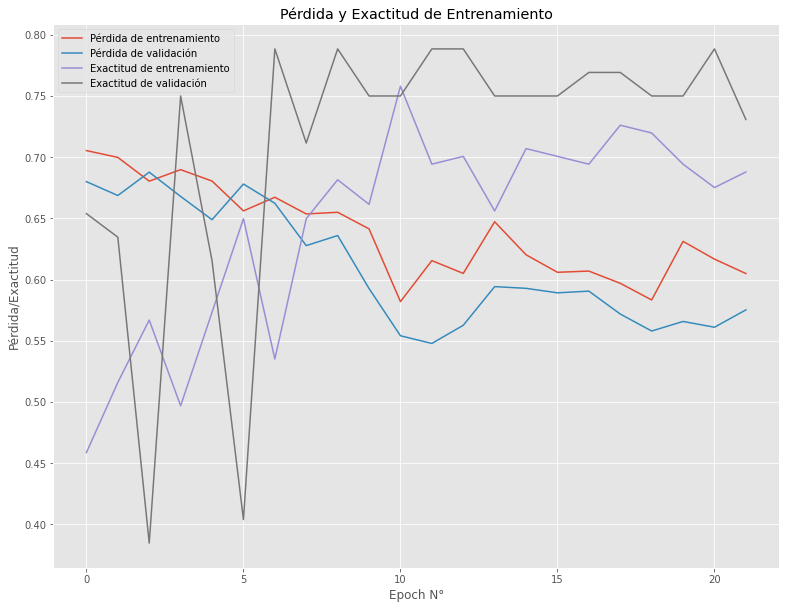

In [25]:
v_tb.plot_history(history)

### PREDICCIONES

In [26]:
predictions = model1.predict(test_images_gr)

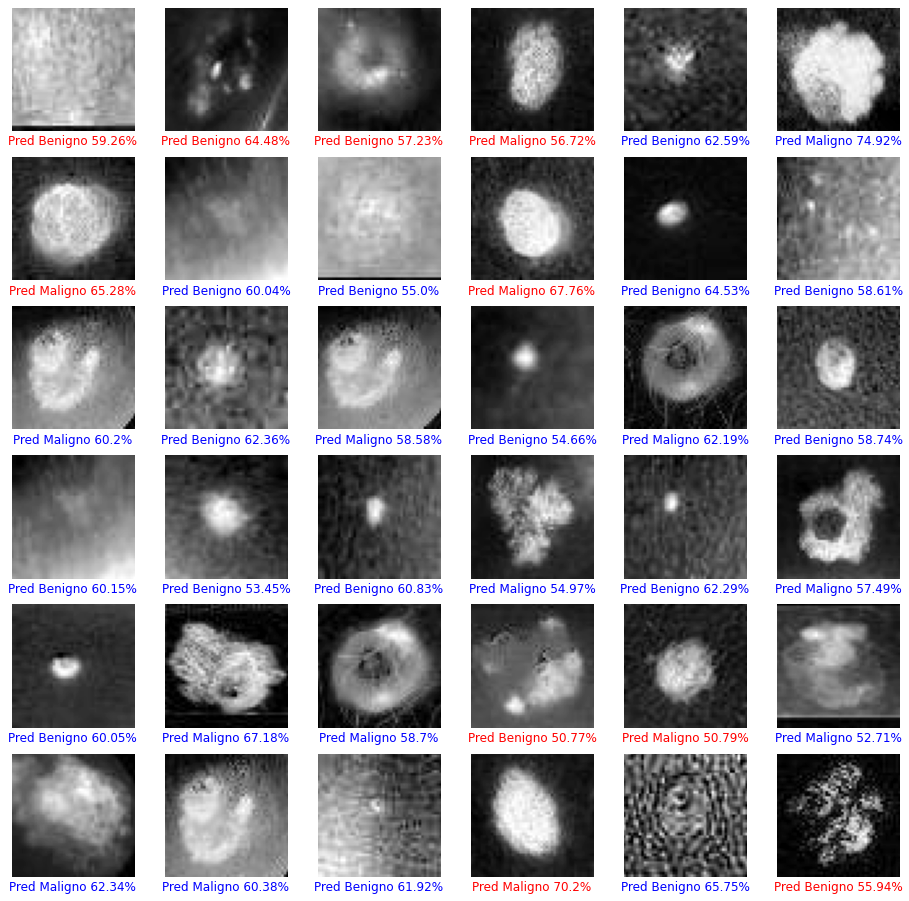

In [27]:
v_tb.plot_test(test_images,test_labels,predictions,6,class_names)

### Resultados: Matriz de Confusión y Reporte de Clasificación

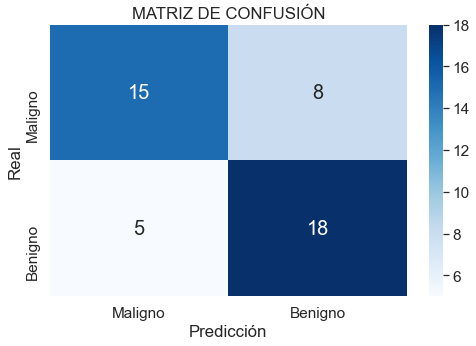

In [28]:
df_mc= v_tb.mat_confusion(predictions, test_labels, class_names,"../reports/mat_conf.csv")

In [29]:
df_mc

,Maligno,Benigno
Maligno,15,8
Benigno,5,18


In [30]:
mat_df = f_tb.cargar_csv("../reports/mat_conf.csv")

NameError: name 'pd' is not defined

In [31]:
mat_df

NameError: name 'mat_df' is not defined

### Reporte de Clasificación

In [33]:
 df_rc = v_tb.clasif_repor (predictions, test_labels, class_names, '../reports/rep_clasif.csv')

In [34]:
df_rc

,precision,recall,f1-score,support
Maligno,0.750000,0.652174,0.697674,23.000000
Benigno,0.692308,0.782609,0.734694,23.000000
accuracy,0.717391,0.717391,0.717391,0.717391
macro avg,0.721154,0.717391,0.716184,46.000000
weighted avg,0.721154,0.717391,0.716184,46.000000


In [36]:
clasif_df=f_tb.cargar_csv("../reports/rep_clasif.csv")
clasif_df

NameError: name 'pd' is not defined

### GUARDAR EL MODELO

In [25]:
ubicacion ="/Users/purbina/Desktop/THE_BRIDGE/DS_MVL/PROYECTOS/projects/final/modelos"
mod_tb.guardar_modelo(model1, ubicacion, test_acc)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Model_0.5555_18-8-30/assets


### CARGAR UN MODELO GUARDADO

In [80]:
ubicacion = "/Users/purbina/Desktop/THE_BRIDGE/DS_MVL/PROYECTOS/projects/final/modelos"
model_name= "Model_0.82609_16-18-16"
modelo_REF = mod_tb.cargar_modelo(ubicacion, model_name)

In [84]:
predictionsA = modelo_REF.predict(test_images_gr)
predictionsB = np.argmax(predictionsA, axis=1)
mcY = confusion_matrix(test_labels, predictionsB)
print('Matriz de confusión')
print(mcY)

Matriz de confusión
[[20  7]
 [ 7 12]]


In [85]:
print(classification_report(test_labels, predictionsB, target_names=class_names))

              precision    recall  f1-score   support

     Maligno       0.74      0.74      0.74        27
     Benigno       0.63      0.63      0.63        19

    accuracy                           0.70        46
   macro avg       0.69      0.69      0.69        46
weighted avg       0.70      0.70      0.70        46



### PRUEBA CON EL MODELO GUARDADO Y CARGADO

In [22]:
os.chdir('/Users/purbina/Desktop/THE_BRIDGE/DS_MVL/PROYECTOS/projects/final/resources/Casos')

In [23]:
foto = "f1.png"
foto_red = f_tb.preparar_imagen(foto,48)
foto_a_pred = f_tb.formatear_imagen(foto_red,48)

In [26]:
res  = a_tb.prediccion_imagen(modelo3, foto_a_pred, class_names)
print(res)

MALIGNO (66.34%) Recomendamos acudir a un especialista para su revisión.


In [50]:
ppp = modelo3.predict(foto_a_pred)
p=pd.DataFrame(ppp)
p.columns = class_names

In [51]:
p

,Maligno,Benigno
0,0.663422,0.336578


In [ ]:
responses = p.to_json()

In [53]:
responses

'{"Maligno":{"0":0.6634224057},"Benigno":{"0":0.3365775943}}'